<a id='home'></a>
### Contents

[Imports](#Imports)

[Dataloading](#Dataloading)

<a id='Imports'></a>
### Imports
[back to contents](#home)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join as p_join
import sys
from collections import Counter
from typing import List, Tuple, Dict, Set, Any, Optional, Callable
from pathlib import Path
sys.path.insert(0, str(Path(os.getcwd()).parent))
import requests
import json
import pickle
from tqdm import tqdm
try:
    from fabulous import color as fb_color
    color_print = lambda x, color='green': print(getattr(fb_color, color)(x)) if 'fb_color' in globals() else print(x)
except Exception as e:
    color_print = lambda x, color='green': print(x)

from bs4 import BeautifulSoup
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [27]:
matplotlib.rcParams['figure.figsize'] = (7, 7)
sns.set_style('whitegrid')

In [3]:
# from src.common_utils import get_container_ipaddr
# from src.minio_utils import initialize_minio_client, load_json_from_minio
from src.db_utils import get_pg_engine

<a id='Dataloading'></a>
### Dataloading
[back to contents](#home)

In [6]:
eng = get_pg_engine()

df = pd.read_sql('select * from raw_data.all_fights_info', eng)
print(f'df: {df.shape[0]:,} x {df.shape[1]:,}')
df.head(3)

df: 7,072 x 165


,names__1,names__2,fight_name,method,round,time,timeformat,referee,date,location,...,per_round_stats__round5__body__1,per_round_stats__round5__body__2,per_round_stats__round5__leg__1,per_round_stats__round5__leg__2,per_round_stats__round5__distance__1,per_round_stats__round5__distance__2,per_round_stats__round5__clinch__1,per_round_stats__round5__clinch__2,per_round_stats__round5__ground__1,per_round_stats__round5__ground__2
0,Andre Muniz,Brendan Allen,middleweight bout,Submission,3,4:25,3 Rnd (5-5-5),Jason Herzog,"February 25, 2023","Las Vegas, Nevada, USA",...,None,None,None,None,None,None,None,None,None,None
1,Augusto Sakai,Don'Tale Mayes,heavyweight bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Kerry Hatley,"February 25, 2023","Las Vegas, Nevada, USA",...,None,None,None,None,None,None,None,None,None,None
2,Tatiana Suarez,Montana De La Rosa,women's flyweight bout,Submission,2,2:51,3 Rnd (5-5-5),Chris Tognoni,"February 25, 2023","Las Vegas, Nevada, USA",...,None,None,None,None,None,None,None,None,None,None


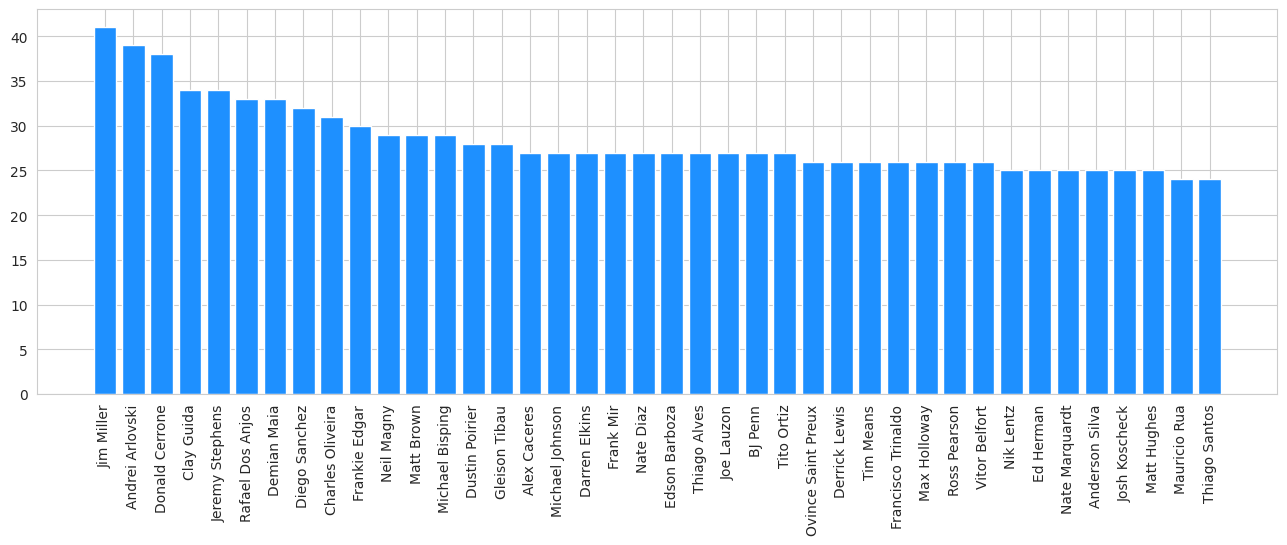

In [29]:
cnt_dict = dict(Counter(df['names__1'].tolist() + df['names__2'].tolist()))
top_k = 40
names, cnts = [], []
for name, cnt in sorted(cnt_dict.items(), key=lambda x: x[1], reverse=True):
    names.append(name)
    cnts.append(cnt)

plt.figure(figsize=(16, 5))
plt.title('Number of fights per fighter', fontsize=15);
plt.title(f'')
plt.bar(names[:top_k], cnts[:top_k], color='dodgerblue')
plt.tick_params(axis='x', rotation=90)

In [33]:
# Number of fights between fighters
df[['names__1', 'names__2']].value_counts()

names__1             names__2         
Tito Ortiz           Ken Shamrock         3
Dustin Poirier       Conor McGregor       3
Deiveson Figueiredo  Brandon Moreno       3
Cain Velasquez       Junior Dos Santos    2
Tyron Woodley        Stephen Thompson     2
                                         ..
Gabriel Benitez      David Onama          1
                     Clay Collard         1
                     Charlie Ontiveros    1
                     Billy Quarantillo    1
Zubaira Tukhugov     Phillipe Nover       1
Length: 6968, dtype: int64

In [68]:
winloose_dict = {}
for name1, name2, wl1, wl2 in df[
        ['names__1', 'names__2', 'winloose_fighter1', 'winloose_fighter2']
    ].itertuples(index=False):
    if name1 not in winloose_dict:
        winloose_dict[name1] = {'wins': 0, 'losses': 0}
    if name2 not in winloose_dict:
        winloose_dict[name2] = {'wins': 0, 'losses': 0}

    winloose_dict[name1]['wins' if wl1.lower() == 'w' else 'losses'] += 1
    winloose_dict[name2]['wins' if wl2.lower() == 'w' else 'losses'] += 1

In [69]:
record_df = pd.DataFrame(winloose_dict).T.reset_index().rename(columns={'index': 'fighter'})
record_df['wl_diff'] = record_df['wins'] - record_df['losses']
record_df

,fighter,wins,losses,wl_diff
0,Andre Muniz,5,1,4
1,Brendan Allen,9,2,7
2,Augusto Sakai,5,4,1
3,Don'Tale Mayes,2,4,-2
4,Tatiana Suarez,6,0,6
...,...,...,...,...
2368,Christian Duncan,1,0,1
2369,Veronica Hardy,1,0,1
2370,Daniel Lacerda,0,1,-1
2371,Vinicius Salvador,0,1,-1


In [71]:
record_df.sort_values(by=['wl_diff', 'wins', 'losses'], ascending=[False, False, True]).head(15)

,fighter,wins,losses,wl_diff
878,Jon Jones,21,2,19
1133,Georges St-Pierre,20,2,18
247,Dustin Poirier,21,7,14
424,Kamaru Usman,15,2,13
473,Amanda Nunes,15,2,13
812,Khabib Nurmagomedov,13,0,13
516,Max Holloway,19,7,12
1045,Demetrious Johnson,15,3,12
46,Islam Makhachev,13,1,12
747,Demian Maia,22,11,11
